# Import Libraries

In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt # Visualization
import matplotlib.dates as mdates # Formatting dates
import seaborn as sns # Visualization
from sklearn.preprocessing import MinMaxScaler
import torch # Library for implementing Deep Neural Network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


# Load and Preprocess dataset

In [37]:
df = pd.read_csv('Biotech_preprocessed_dataset_with_outliers.csv')
df['Time'] = pd.to_datetime(df['Time'])
df['Date'] = df['Time'].dt.date
df.set_index('Date', inplace=True)
df

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-01-04,2024-01-04 15:00:00,15:00:00,15,Thursday,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 16:00:00,16:00:00,16,Thursday,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 17:00:00,17:00:00,17,Thursday,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 18:00:00,18:00:00,18,Thursday,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 19:00:00,19:00:00,19,Thursday,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,2024-07-08 05:00:00,05:00:00,5,Monday,1040.0,635.0,259.0,146.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 06:00:00,06:00:00,6,Monday,1414.0,1023.0,251.0,140.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 07:00:00,07:00:00,7,Monday,571.0,225.0,243.0,103.0,False,True,False,False,False,False,False,False


In [38]:
df.describe()

,Time,Hour,Total (W),Phase_A (W),Phase_B (W),Phase_C (W)
count,4459,4459.000000,4459.000000,4459.000000,4459.000000,4459.000000
mean,2024-04-06 12:00:00,11.499439,1159.329895,586.073111,372.809823,200.400987
min,2024-01-04 15:00:00,0.000000,316.000000,63.000000,94.000000,45.000000
25%,2024-02-20 01:30:00,5.000000,733.000000,271.000000,238.000000,121.000000
50%,2024-04-06 12:00:00,11.000000,943.000000,418.000000,306.000000,183.000000
75%,2024-05-22 22:30:00,18.000000,1314.500000,748.000000,395.000000,187.000000
max,2024-07-08 09:00:00,23.000000,7054.000000,6390.000000,2248.000000,3682.000000
std,NaN,6.926661,767.035561,608.340687,252.884904,177.315925


In [39]:
df_holiday = df[df['Holiday'] == True]
df_holiday

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-01-06,2024-01-06 00:00:00,00:00:00,0,Saturday,732.0,196.0,349.0,187.0,False,False,True,False,False,False,False,True
2024-01-06,2024-01-06 01:00:00,01:00:00,1,Saturday,1226.0,612.0,428.0,186.0,False,False,True,False,False,False,False,True
2024-01-06,2024-01-06 02:00:00,02:00:00,2,Saturday,593.0,81.0,325.0,187.0,False,False,True,False,False,False,False,True
2024-01-06,2024-01-06 03:00:00,03:00:00,3,Saturday,1148.0,644.0,317.0,187.0,False,False,True,False,False,False,False,True
2024-01-06,2024-01-06 04:00:00,04:00:00,4,Saturday,655.0,81.0,386.0,188.0,False,False,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-06,2024-07-06 19:00:00,19:00:00,19,Saturday,1667.0,1085.0,445.0,137.0,False,False,True,False,False,False,False,True
2024-07-06,2024-07-06 20:00:00,20:00:00,20,Saturday,1628.0,1141.0,338.0,149.0,False,False,True,False,False,False,False,True
2024-07-06,2024-07-06 21:00:00,21:00:00,21,Saturday,1013.0,482.0,385.0,146.0,False,False,True,False,False,False,False,True


In [40]:
df_office_day = df[df['Holiday'] == False]
df_office_day

,Time,TOD,Hour,Day,Total (W),Phase_A (W),Phase_B (W),Phase_C (W),Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Holiday
Date,,,,,,,,,,,,,,,,
2024-01-04,2024-01-04 15:00:00,15:00:00,15,Thursday,821.0,207.0,467.0,147.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 16:00:00,16:00:00,16,Thursday,741.0,298.0,329.0,114.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 17:00:00,17:00:00,17,Thursday,776.0,363.0,278.0,135.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 18:00:00,18:00:00,18,Thursday,1260.0,659.0,419.0,182.0,False,False,False,False,True,False,False,False
2024-01-04,2024-01-04 19:00:00,19:00:00,19,Thursday,973.0,381.0,410.0,182.0,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-08,2024-07-08 05:00:00,05:00:00,5,Monday,1040.0,635.0,259.0,146.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 06:00:00,06:00:00,6,Monday,1414.0,1023.0,251.0,140.0,False,True,False,False,False,False,False,False
2024-07-08,2024-07-08 07:00:00,07:00:00,7,Monday,571.0,225.0,243.0,103.0,False,True,False,False,False,False,False,False


<Axes: xlabel='Date'>

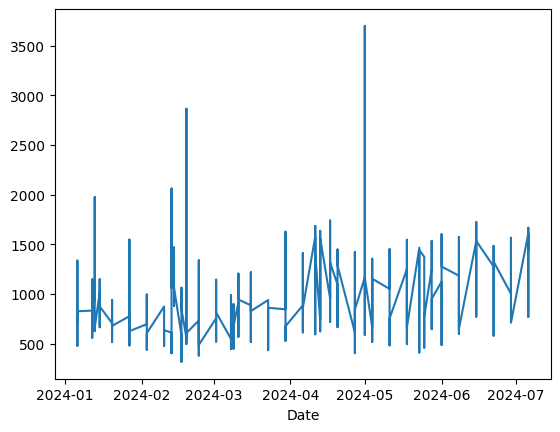

In [41]:
df_holiday['Total (W)'].plot()

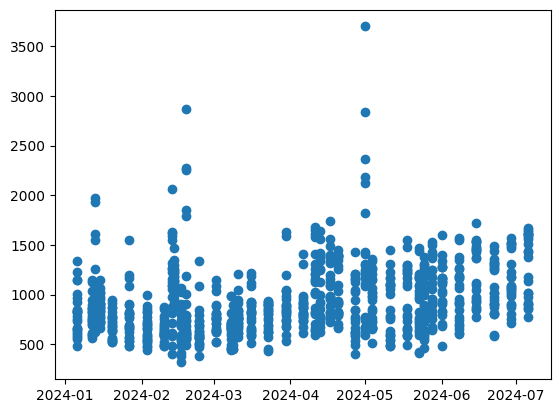

In [42]:
plt.scatter(df_holiday.index, df_holiday['Total (W)'])
plt.show()

<Axes: xlabel='Date'>

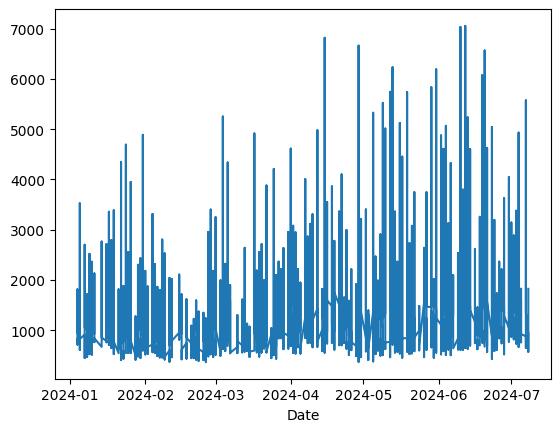

In [43]:
df_office_day['Total (W)'].plot()

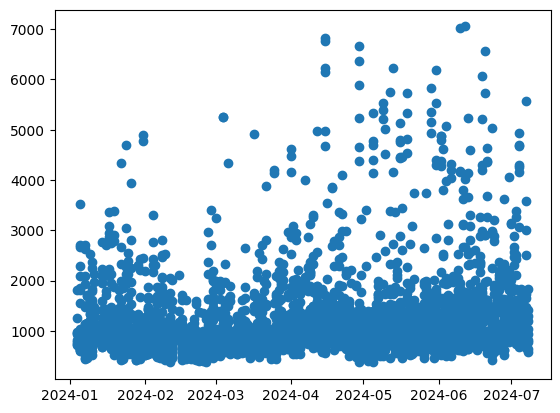

In [44]:
plt.scatter(df_office_day.index, df_office_day['Total (W)'])
plt.show()

In [45]:
print(df_holiday['Total (W)'].mean())
print(df_office_day['Total (W)'].mean())

922.5694444444445
1222.2330400227079


**Drop Unnecessary columns** \
We are going to forecast total load based only on the previous values of total load. So, we wiil keep only the 'Total (W)' column.

In [46]:
df_office_day = pd.DataFrame(df_office_day['Total (W)'])
df_office_day

,Total (W)
Date,
2024-01-04,821.0
2024-01-04,741.0
2024-01-04,776.0
2024-01-04,1260.0
2024-01-04,973.0
...,...
2024-07-08,1040.0
2024-07-08,1414.0
2024-07-08,571.0


In [47]:
df_holiday = pd.DataFrame(df_holiday['Total (W)'])
df_holiday

,Total (W)
Date,
2024-01-06,732.0
2024-01-06,1226.0
2024-01-06,593.0
2024-01-06,1148.0
2024-01-06,655.0
...,...
2024-07-06,1667.0
2024-07-06,1628.0
2024-07-06,1013.0


**Separate train and test data**

In [48]:
training_data_len = int(len(df_office_day)*0.8)
print(training_data_len)

train_data = df_office_day[:training_data_len]
test_data = df_office_day[training_data_len:]

print(train_data.shape, test_data.shape)

2818
(2818, 1) (705, 1)


In [49]:
print(train_data['Total (W)'].mean())
print(test_data['Total (W)'].mean())

1155.5035486160398
1488.9617021276595


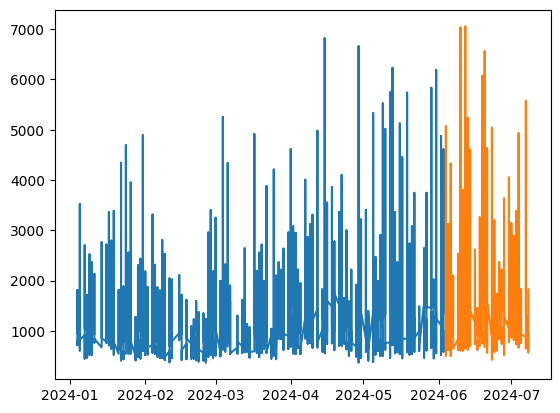

In [50]:
plt.plot(train_data['Total (W)'])
plt.plot(test_data['Total (W)'])
plt.show()

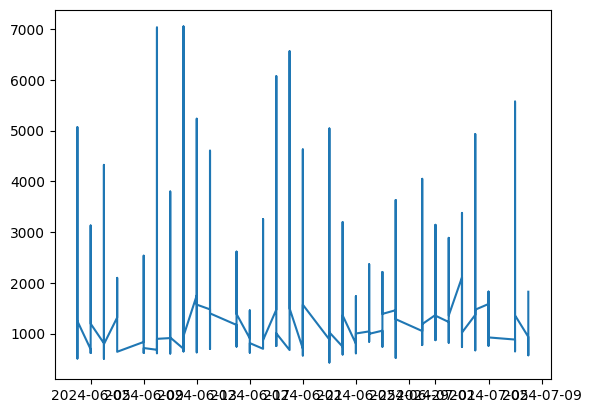

In [51]:
plt.plot(test_data['Total (W)'])
plt.show()

In [52]:
dataset_train = train_data['Total (W)'].values
dataset_train = np.reshape(dataset_train, (-1, 1))
dataset_train.shape


(2818, 1)

In [53]:
dataset_test = test_data['Total (W)'].values
dataset_test = np.reshape(dataset_test, (-1, 1))
dataset_test.shape

(705, 1)

**Scaling**

In [54]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_train = scaler.fit_transform(dataset_train)
scaled_test = scaler.fit_transform(dataset_test)
print(scaled_train[:5])
print(scaled_test[:5])

[[-0.86011166]
 [-0.88492556]
 [-0.87406948]
 [-0.72394541]
 [-0.81296526]]
[[-0.77086792]
 [-0.71109434]
 [-0.86837736]
 [-0.93207547]
 [-0.85781132]]


**Create Sequences**

In [55]:
sequence_length = 24
X_train, y_train = [], []
for i in range(len(scaled_train)-sequence_length):
  X_train.append(scaled_train[i:i+sequence_length])
  y_train.append(scaled_train[i+1:i+sequence_length+1])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape, y_train.shape

((2794, 24, 1), (2794, 24, 1))

In [56]:
X_test, y_test = [], []
for i in range(len(scaled_test)-sequence_length):
  X_test.append(scaled_test[i:i+sequence_length])
  y_test.append(scaled_test[i+1:i+sequence_length+1])
X_test, y_test = np.array(X_test), np.array(y_test)


**Convert to Tensors**

In [57]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
print(X_test.shape, y_test.shape)

torch.Size([2794, 24, 1]) torch.Size([2794, 24, 1])
torch.Size([681, 24, 1]) torch.Size([681, 24, 1])


# Create Model

In [160]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    out, _ = self.lstm(x)
    out = self.fc(out)
    return out


In [161]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [162]:
input_size = 1
num_layers = 2
hidden_size = 64
output_size = 1

model = LSTM(input_size, hidden_size, num_layers).to(device)
loss_fn = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


**Torch Dataloader**

In [163]:
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [164]:
for x, y in train_loader:
	print(f'X shape: {x.shape}, y shape: {y.shape}')
	break

X shape: torch.Size([32, 24, 1]), y shape: torch.Size([32, 24, 1])


# Train the Model

In [165]:
num_epochs = 40
train_loss_hist =[]
test_loss_hist =[]
train_mape_hist = []
test_mape_hist = []
# Training loop
for epoch in range(num_epochs):
	total_loss = 0.0
	total_mape = 0.0

	# Training
	model.train()
	for batch_X, batch_y in train_loader:
		batch_X, batch_y = batch_X.to(device), batch_y.to(device)
		predictions = model(batch_X)
		loss = loss_fn(predictions, batch_y)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		total_loss += loss.item()
		total_mape += torch.mean(torch.abs((predictions - batch_y)/(batch_y+1e-8))*100.0)

	# Calculate average training loss and accuracy
	average_loss = total_loss / len(train_loader)
	train_loss_hist.append(average_loss)
	average_mape = total_mape / len(train_loader)
	train_mape_hist.append(average_mape)

	# Validation on test data
	model.eval()
	with torch.no_grad():
		total_test_loss = 0.0
		total_test_mape = 0.0

		for batch_X_test, batch_y_test in test_loader:
			batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
			predictions_test = model(batch_X_test)
			test_loss = loss_fn(predictions_test, batch_y_test)

			total_test_mape += torch.mean(torch.abs((predictions_test - batch_y_test)/(batch_y_test+1e-8))*100.0)
			total_test_loss += test_loss.item()

		# Calculate average test loss and accuracy
		average_test_loss = total_test_loss / len(test_loader)
		test_loss_hist.append(average_test_loss)
		average_test_mape = total_test_mape / len(test_loader)
		test_mape_hist.append(average_test_mape)
	if (epoch+1)%4==0:
		print(f'Epoch [{epoch+1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')


Epoch [4/40] - Training Loss: 0.0434, Test Loss: 0.0598
Epoch [8/40] - Training Loss: 0.0388, Test Loss: 0.0586
Epoch [12/40] - Training Loss: 0.0378, Test Loss: 0.0613
Epoch [16/40] - Training Loss: 0.0371, Test Loss: 0.0599
Epoch [20/40] - Training Loss: 0.0365, Test Loss: 0.0589
Epoch [24/40] - Training Loss: 0.0358, Test Loss: 0.0583
Epoch [28/40] - Training Loss: 0.0349, Test Loss: 0.0586
Epoch [32/40] - Training Loss: 0.0345, Test Loss: 0.0588
Epoch [36/40] - Training Loss: 0.0336, Test Loss: 0.0579
Epoch [40/40] - Training Loss: 0.0327, Test Loss: 0.0592


In [166]:
for i in range(len(train_mape_hist)):
  if (i+1) % 4 == 0:
    print(f'Epoch {i+1} - Training MAPE: {train_mape_hist[i]:.2f}, Test MAPE: {test_mape_hist[i]:.2f}')

Epoch 4 - Training MAPE: 30.83, Test MAPE: 55.21
Epoch 8 - Training MAPE: 29.14, Test MAPE: 52.61
Epoch 12 - Training MAPE: 28.75, Test MAPE: 54.35
Epoch 16 - Training MAPE: 28.62, Test MAPE: 53.75
Epoch 20 - Training MAPE: 28.38, Test MAPE: 53.23
Epoch 24 - Training MAPE: 28.16, Test MAPE: 53.14
Epoch 28 - Training MAPE: 27.86, Test MAPE: 53.82
Epoch 32 - Training MAPE: 27.72, Test MAPE: 53.24
Epoch 36 - Training MAPE: 27.38, Test MAPE: 52.64
Epoch 40 - Training MAPE: 27.16, Test MAPE: 53.63


# Plots

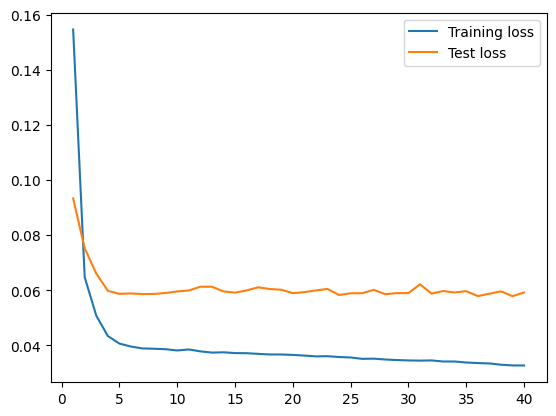

In [167]:
x = np.linspace(1,num_epochs,num_epochs)
plt.plot(x,train_loss_hist,scalex=True, label="Training loss")
plt.plot(x, test_loss_hist, label="Test loss")
plt.legend()
plt.show()
